<a href="https://colab.research.google.com/github/olorunfemibabalola/Bias-Detection-NLP/blob/main/Deduct_or_Infer_Assigment_Walkthrough_2_of_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deduct_or_Infer_Assigment_Walkthrough. Part 2 of 2
This is a simpified walthough. When completed it amounts to a basic mark.
The walthough covers Task 4. In short, we will:
Task 4

- 4.1 Load the data and configure the network.
Two configurations:
   - A standad network (/uncomenting the blocs below "non-ODE" below and commenting the Neural ODE adjacent ones)
   - A neural ODE
- 4.2 Train and validate it with the same validation period we used for the models.

Task 5 is the abstract and references, not covered in this walkthrough since this is explained in Research Methods.
This concludes the assigment.

## Task 4
### 4.1 Load data and configure the network
#### 4.1.1. Imports and real data

In [1]:
!pip install torch torchdiffeq matplotlib

In [2]:
# Commenting/uncomenting the blocs below "non-ODE" we run a standard
# deep network instead of a Neural ODE.

# # We need the new library "torchdiffeq" to integrate
#the "left hand side" of the Neural ODE.
#The rest is
# pip install torch torchdiffeq matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint   # Neural ODE solver
X=np.loadtxt('DataSetRatesWalkthrough 2.txt')

#Network size and activation function
input_dims = len(X[0,:])
output_dims = input_dims
dt=0.01
t=dt*np.linspace(0,X.shape[0]-1,X.shape[0])

# Supervised pairs: X_t -> X_{t+1}
X_input  = X[:-1, :]   # (N-1, 2)
X_target = X[1:, :]    # (N-1, 2)

# Train/validation split.
#In our case, only the last 154 patterns will be used for validation
#See "Deduct_or_Infer_Assigment_Walkthrough. Part 1 of 2.mlx"

split_index = len(X_input) - 154
X_train_np = X_input[:split_index,:]
Y_train_np = X_target[:split_index,:]
X_val_np   = X_input[split_index:,:]
Y_val_np   = X_target[split_index:,:]
t_val=t[split_index+1:]

#Addition: We will check first if there is a GPU available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU not available, using CPU instead")
    device = torch.device("cpu")

# Convert to PyTorch tensors (float32)
X_train = torch.from_numpy(X_train_np).float()

X_train = X_train.to(device) #Addition: This is to make sure is where we want
#Probably unnecessary if we do all in the same device.
#Just safe practice.
Y_train = torch.from_numpy(Y_train_np).float()
Y_train = Y_train.to(device)
X_val   = torch.from_numpy(X_val_np).float()
X_val = X_val.to(device)
Y_val   = torch.from_numpy(Y_val_np).float()
Y_val = Y_val.to(device)
print(f"Training data shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {Y_val.shape}")

GPU not available, using CPU instead
Training data shape: torch.Size([4039, 2]), torch.Size([4039, 2])
Validation data shape: torch.Size([154, 2]), torch.Size([154, 2])


#### 4.1.2. Right-hand side (deep network) design

In [3]:
# Commenting/uncomenting the blocs below "non-ODE" we run a standard
# deep network instead of a Neural ODE.

# Neural ODE: du(l,t)/dl = f(u(l,t)),  l ∈ [0, 1]
#Right-hand side : Hidden Layer structure: affine transform *a^{layer l)-> Layer normalization -> ReLU
#We could apply other normalizations, or layer normalization after the activation.
#We can also try other activation functions. -check prevous code:

input_dimension=X.shape[1]
output_dimension=X.shape[1]

#ODE
neurons_per_layer=10
num_hidden_layers=2#Over 5 is disastrous: not enough data to train so many parameters
#Remember to comment the 2 lines below if using Neural ODEs.
#neurons_per_layer=...
#num_hidden_layers=...
#

#Non-ODE.
neurons_per_layer=20
num_hidden_layers=8
#Ad comment the two lines above, but no need.
#
num_epochs = num_hidden_layers*neurons_per_layer*5

#All classes we define must inherit from nn.Module
#otheriwse PyTorch won't be able to track parameters
#and compute the error gradients automatically.
#Here, the entire deep network is a class that creates layers.

class f_DeepNet(nn.Module):
    #Addition: This the same to what we did before
    #However, we define and then assemble now the hidden layers
    # with nn.Sequential.
    def __init__(self, input_dimension=2, neurons_per_layer=32,\
                 output_dimension=2, num_hidden_layers=3):
        super().__init__()
        layers = []

        # Stack num_hidden_layers blocks: Linear(in_dim -> hidden_dim) + Tanh
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dimension, neurons_per_layer))

            #Non-ODE.
            #Comment or uncomment, since layer norm possibly unnecessary for Neural ODEs, as depth is continuous
            layers.append(nn.LayerNorm(neurons_per_layer))
            #

            layers.append(nn.ReLU())
            input_dimension = neurons_per_layer  # from now on, hidden -> hidden

        # Final linear layer back to state dimension.
        layers.append(nn.Linear(input_dimension, output_dimension))
        # Addition: Automatically stack layers into a network
        #No need of a loop as we did in
        # "III_2_Code_Demos_Deep_Learners_Principled_Model.jpynb".
        self.net = nn.Sequential(*layers)

    #ODE
    # def forward(self, l, x):
    #     return self.net(x)
    #

    #Non -ODE.
    def forward(self, x):
        return self.net(x)
    #And comment previous line with the extra argument "l".:
    #def forward(self, l, x):
    #    return self.net(x)


# We define an abstract "depth grid": from l = 0 to l = 1.
# This is the continuous analogue of going from layer 0 to layer 1.
#Again, useless for not a neural ODE, but needed for the integration step.

#ODE
#depth_grid_of_l = (torch.tensor([0.0, 1.0], dtype=torch.float32)).to(device)
#

#Non-ODE.
 #Simply comment the line above "depth_grid_of_l = ..."
 #

#Auxiliary methods to compute normalized errors
def NRMSE(y_pred, y_true):
    #Emili's index (unpublished).
    #Is a way of normalizing the RMSE to the variance of the observed signal
    #to have a relative error measure between 0 and 100%
    err=y_pred-y_true
    obs_norm=torch.norm(y_true-torch.mean(y_true))
    nrmse_value=100*((( 100*(1- (torch.norm(err) /obs_norm))   )+100)/200)
    #This is to have 0-100% scale, with 100% being perfect prediction
    #If you remove the scaling, it will be in the range 0-1
    return nrmse_value
def NMAE(y_pred, y_true):
    #Emili's index (unpublished).
    #Is a way of normalizing the RMSE to the variance of the observed signal
    #to have a relative error measure between 0 and 100%
    err=torch.abs(y_pred-y_true)
    obs_abs=torch.abs(y_true-torch.mean(y_true))
    nmae_value=100*((( 100*(1- (torch.sum(err) /torch.sum(obs_abs)))   )+100)/200)
    #This is to have 0-100% scale, with 100% being perfect prediction
    #If you remove the scaling, it will be in the range 0-1
    return nmae_value

### 4.2. Model instantiation, training, integration and validation.

If neural ODE, the integration is the additional step
We want to learn learn $x_t$ $\rightarrow$ $x_{t+1}$.

#### 4.2.1. Training and validation

In [4]:
# Instantiate the right hand side and send it to the GPU if available
model= f_DeepNet(input_dimension,neurons_per_layer, \
    output_dimension,num_hidden_layers).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)
print("N epochs:", num_epochs)

#Training setup (full-batch gradient descent)
error_function = nn.MSELoss() #This is the mean square error loss function (see slides)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#You can see a full discussion of Adam in Bishop and Bishop (2023) Deep Learning book, secion 7.3.3 (or in the original Adam paper,
# "Kingma and Ba. Adam: A Method for Stochastic Optimization. ICLR 2015. https://arxiv.org/abs/1412.6980"
train_error_per_epoch = []
val_error_per_epoch = []

for epoch in range(num_epochs):
    #This sets the model to training mode (this is specially important for
    # layers that we did not use here)
    #We can omit it if we don't use such layers, as the traing takes place
    # anyway next. However, it's good practice to include it
    model.train()

    #This clears the error function gradients from the previous epoch.
    #It is good practice to do this before computing the new gradients
    # because PyTorch accumulates gradients by default.
    #We want to start from the latest weights only, but afresh at each
    # epoch in terms of how much to change them.
    optimizer.zero_grad()
    #
    # This returns a tensor of shape (len(depth_grid_of_l), N_train, output_dimension):
    # where index 1 is the solution at l = 1: our model prediction for the next step.
    #index 0 is just the solution at l = 0 (i.e. the input data).

    #ODE
    # Trajectory_pred = odeint(model, X_train, depth_grid_of_l)
    # Y_pred = Trajectory_pred[-1]# solution at l = 1,  2D array of shape (N_train, output_dimension) with the predictions
    #

    #Non-ODE
    Y_pred = model(X_train)#Simple forward pass. comment the two lines above
    #"Trajectory_pred = ...""
    #"Y_pred = ...
    #

    train_loss = error_function(Y_pred, Y_train)#This simpy computes the mean square error between predicted
                                                #and true outputs.
    #This is the same as before, since we have
    #already integrated the ODE. the function computes the gradients of the error function w.r.t. all model parameters
    #automatically using backpropagation (see slides). It uses auto-differentiation under the hood.
    # You can check more in Bishop and Bishop (2023) Deep Learning book, section 8.2 (pytorch used backward-mode autodiff)
    #The gradients are stored in param.grad for each parameter.

    train_loss.backward()
    optimizer.step()#This updates the model parameters using the computed gradients and the optimizer (Adam here).
    #It iterates over all parameters of the "model" object.
    # Model parameters are fields (attributes of "model").
    # They themselves are objects that contain a field called "data" with the current weight value and "grad"
    # wich has the gradients associated this specifc parameters, freshly stored there by the backward() function.

    model.eval()  # Set evaluation mode as before.
    #The nex instruction sets the context so that no gradients are computed during validation
    #This is important for memory efficiency and speed, as we do not need gradients at
    # validation.
    with torch.no_grad():

        #ODE
        # Trajectory_val_pred = odeint(model, X_val, depth_grid_of_l)
        # Y_val_pred = Trajectory_val_pred[-1]
        #

        #Non-ODE
        Y_val_pred = model(X_val)
        #Comment the two lines above:
        #"Trajectory_val_pred =...""
        #"Y_val_pred =..."

        val_loss = error_function(Y_val_pred, Y_val)

    train_error_per_epoch.append(train_loss.item())#We store the average training loss per sample
    val_error_per_epoch.append(val_loss.item())

    #The "detach().cpu().numpy()" is to move the tensors to CPU (if they were in GPU)
    #and convert them to numpy arrays for processing with numpy functions.
    #detach() means "remove all variables tracking" so that no gradients are computed for these operations.
    #otherwise, numpy would complain as it cannot handle tensors with gradients.
    det_coef_train = 100*(  (np.corrcoef(Y_train.detach().cpu().numpy().flatten(), \
        Y_pred.detach().cpu().numpy().flatten())[0,1])**2  )
    det_coef_val = 100*(  (np.corrcoef(Y_val.detach().cpu().numpy().flatten(),\
        Y_val_pred.detach().cpu().numpy().flatten())[0,1])**2  )
    NRMSE_train = NRMSE(Y_pred, Y_train).item()
    NRMSE_val = NRMSE(Y_val_pred, Y_val).item()
    NMAE_train = NMAE(Y_pred, Y_train).item()
    NMAE_val = NMAE(Y_val_pred, Y_val).item()

     #As before, print every 20 epochs plus the last one
    if epoch%20==0 or epoch==num_epochs-1:

        print(f"Epoch {epoch+1}. Training raw mse={train_loss.item():.4f}. Relative parameters (%): Determination Coeff.={det_coef_train:.2f}, NRMSE={NRMSE_train:.2f}, NMAE={NMAE_train:.2f}\n \
         Validation mse={val_loss.item():.4f} (%): Determination Coeff.={det_coef_val:.2f}, NRMSE={NRMSE_val:.2f}, NMAE={NMAE_val:.2f}")

f_DeepNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=20, out_features=20, bias=True)
    (10): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (14): ReLU()
    (15): Linear(in_features=20, out_features=20, bias=True)
    (16): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (17): ReLU()
    (18): Linear(in_features=20, out_features=20, bias=True)
    (19): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (20):

#### 4.2.2. Plotting error functions.

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlations neuron  4  between true and predicted outputs (validation period): nan
Correlations neuron  6  between true and predicted outputs (validation period): 0.9710628007307059


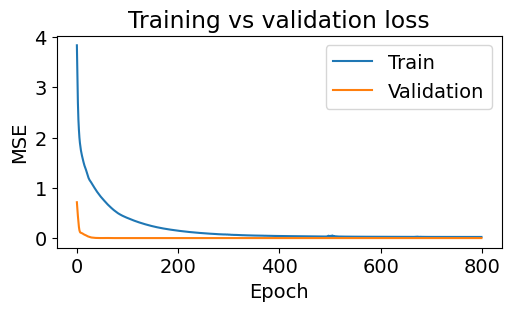

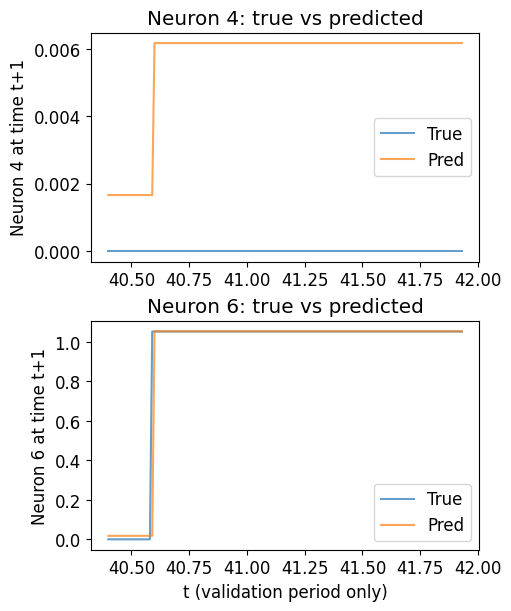

In [5]:

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(5,3),layout='constrained')
plt.plot(train_error_per_epoch, label="Train")
plt.plot(val_error_per_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs validation loss")
plt.rcParams.update({'font.size': 12})
#One-step prediction
model.eval()
with torch.no_grad():

    # ODE
    # Trajectory_val_pred = odeint(model, X_val, depth_grid_of_l)
    # X_next_hat  = (Trajectory_val_pred[-1]).detach().cpu().numpy()
    #

    #Non-ODE
        X_next_hat = model(X_val).detach().cpu().numpy()

X_next_true =(Y_val).detach().cpu().numpy()

#Display up to six output dimmensions if available in two rows
#I only care for the validation period here
max_columns = min(3, X_next_true.shape[1]-1)
plt.figure(figsize=(5*max_columns,6),layout='constrained')

Neurons_names=["4","6"]

for i in range(2*max_columns):
    plt.subplot(2, max_columns, i+1)
    plt.plot(t_val, X_next_true[:, i], label=f"True", alpha=0.7)
    plt.plot(t_val, X_next_hat[:, i], label=f"Pred", alpha=0.7)
    if i>=max_columns:
        plt.xlabel("t (validation period only)")
    plt.ylabel(f"Neuron {Neurons_names[i]} at time t+1")
    plt.legend()
    plt.title(f"Neuron {Neurons_names[i]}: true vs predicted")

#Correlations now
c4=np.corrcoef(X_next_true[:,0], X_next_hat[:,0])
print("Correlations neuron ", Neurons_names[0], " between true and predicted outputs (validation period):", c4[0,1])
c6=np.corrcoef(X_next_true[:,1], X_next_hat[:,1])
print("Correlations neuron ", Neurons_names[1], " between true and predicted outputs (validation period):", c6[0,1])

## End of Task 4 and all assigment results (Tasks 2,3,4).

This concludes Task 4 of the assigment (either/and with an "discrete-layers" architecture or a Neural ODE). What remains now is to compare these two correlation coefficients (and other validation measures) with the correlation coeffs.
we obtained between real and modelled rates in the same validation period with principled-based models (Task 3)>Thus, what is best, to Deduct or to Infer? does it always depend on the question we want to ask?


## Task 5

### 5.1 Abstract
 -remember from Research Methods, the abstract needs strucure, for instance:

1. State of the art -why is important and what at has been done?
2. State of the art -what has NOT been done and why?
3. Methodological approach -what to do you propose to adress what has NOT been done?
4. Results -what did you get?
5. Discussion -how are results with respect to the state of the art? What they suggest?
6. Concluding remarks and takeaway message -what are hte lessons learned and your follow-up suggestions?

### 5.2 References

- The more specific (chapter/pages in a book, niche papers), the better
- Unrelated papers from GPT can be a bit problematic if we do not read them -less niche and unrelated to what you reference

# <font color="red"> IMPORTANT: *More ideas for a good assigment and extra details in the Appendix of "Deduct or Infer?"*

